In [22]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
def convert_duration_to_seconds(duration):
    pattern = r'PT(\d+H)?(\d+M)?(\d+S)?'
    hours, minutes, seconds = re.match(pattern, duration).groups()
    
    total_seconds = 0
    if hours:
        total_seconds += int(hours[:-1]) * 3600
    if minutes:
        total_seconds += int(minutes[:-1]) * 60
    if seconds:
        total_seconds += int(seconds[:-1])
    
    return total_seconds

In [24]:
# Import datasets
train_df = pd.read_csv("../data/dataset/train/train.csv")
validate_df = pd.read_csv("../data/dataset/validation/validation.csv")
train_audio_df = pd.read_csv("../data/dataset/train/train_audio_clean.csv")
validate_audio_df = pd.read_csv("../data/dataset/validation/validation_audio_clean.csv")
train_audio2_df = pd.read_csv("../data/dataset/train/train_audio2.csv")
validate_audio2_df = pd.read_csv("../data/dataset/validation/validation_audio2.csv")
train_visual_df = pd.read_csv("../data/dataset/train/train_visual.csv")
validate_visual_df = pd.read_csv("../data/dataset/validation/validation_visual.csv")

In [25]:
# Merging in audio and visual data
train_df = train_df.merge(train_visual_df, on='id')
train_df = train_df.merge(train_audio_df, on='id')
train_df = train_df.merge(train_audio2_df, on='id')
validate_df = validate_df.merge(validate_visual_df, on='id')
validate_df = validate_df.merge(validate_audio_df, on='id')
validate_df = validate_df.merge(validate_audio2_df, on='id')

In [129]:
# Set the input training data
# duration_train = train_df['duration'].apply(convert_duration_to_seconds).values.reshape(-1, 1)
X_train = train_df[['colorfulness', 'speech_rate', 'pitch_mean']]
# X_train['duration'] = duration_train

In [139]:
# Set the output training data
# y_train = train_df['likes_per_view']
y_train = train_df['views_per_week']

In [131]:
# Set the input predictive data
# duration_validation = validate_df['duration'].apply(convert_duration_to_seconds).values.reshape(-1, 1)
X_validate = validate_df[['colorfulness', 'speech_rate', 'pitch_mean']]
# X_validate['duration'] = duration_validation

In [140]:
# Scale the features using standardization
scaler = StandardScaler()
X_train.reset_index()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_validate)

# Confirm scaling worked correctly
# print("Training input data mean after scale = " + str(np.mean(X_train_scaled)))
# print("Training input data variance after scale = " + str(np.var(X_train_scaled)))
# print("Testing input data mean after scale = " + str(np.mean(X_train_scaled)))
# print("Testind input data variance after scale = " + str(np.var(X_train_scaled)))

In [141]:
# Fill Nans if necessary
X_train_scaled[np.isnan(X_train_scaled)] = 0

In [142]:
# Fit and predict the linear regression model
reg = LinearRegression().fit(X_train_scaled, y_train)
predictions = reg.predict(X_test_scaled)
print(predictions)

[392.35557585 306.54503169 177.23903095 298.70381227 289.24729808
 252.79580441 316.11439599 327.00133322 320.00855413 195.69798471
 275.05407375 330.90216399 268.02290308 348.22252858 270.20683461
   2.82259133 333.33088704 124.56924533 300.11956668 419.39290386
 308.93889616 191.65097217 244.14240389 255.87376994 329.175305
 261.99727077 389.50779594 218.01938082 304.19219858 364.52829979
 248.60435211 324.13993222 321.66065233 329.64414515 255.62688005
 255.17709114 205.177814    75.39210195 245.74533254 302.55407892
 130.9396155  378.52606005 312.60470084]


In [135]:
# Output lpv predictions to csv file
# MAKE SURE ITS THE RIGHT FILE!!!
linreg_df = pd.DataFrame(columns=['id', 'likes_per_view_predicted', 'likes_per_view_actual'])
linreg_df['id'] = validate_df['id']
linreg_df['likes_per_view_predicted'] = predictions
linreg_df['likes_per_view_actual'] = validate_df['likes_per_view']
linreg_df.to_csv("../data/dataset/models/linreg/6_n.csv", header=True, index=False)

In [143]:
# Output vpw predictions to csv file
# MAKE SURE ITS THE RIGHT FILE!!!!
linreg_df['views_per_week_predicted'] = predictions
linreg_df['views_per_week_actual'] = validate_df['views_per_week']
linreg_df.to_csv("../data/dataset/models/linreg/6_n.csv", header=True, index=False)

In [144]:
# Find feature importance through coefficients
importance = reg.coef_

# Find intercept
intercept = reg.intercept_
print("intercept: " + str(intercept))

# Summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))

intercept: 268.7116168405715
Feature: 0, Score: -20.69429
Feature: 1, Score: 76.82583
Feature: 2, Score: 23.92157


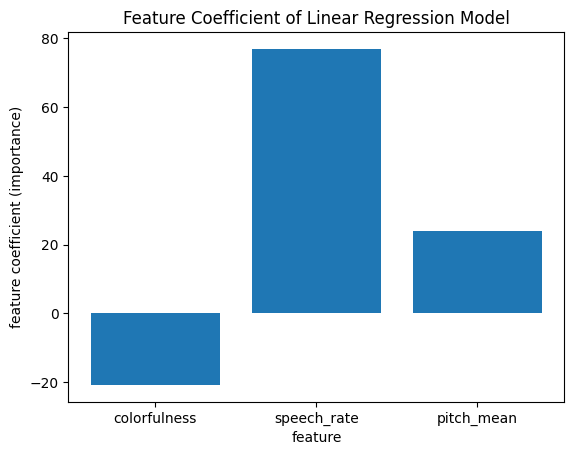

In [145]:
# plot feature importance
plt.bar(['colorfulness', 'speech_rate', 'pitch_mean'], importance)
plt.xlabel('feature')
plt.ylabel('feature coefficient (importance)')
plt.title('Feature Coefficient of Linear Regression Model')
plt.show()

In [146]:
# Calculate errors
# Likes
actual_outputs = linreg_df['likes_per_view_actual']*100
predicted_outputs = linreg_df['likes_per_view_predicted']*100

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_outputs, predicted_outputs)
print("Mean Absolute Error for LPV:", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(actual_outputs, predicted_outputs, squared=False)
print("Root Mean Squared Error for LPV:", rmse)

# Views
actual_outputs = linreg_df['views_per_week_actual']
predicted_outputs = linreg_df['views_per_week_predicted']

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_outputs, predicted_outputs)
print("Mean Absolute Error for VPW:", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(actual_outputs, predicted_outputs, squared=False)
print("Root Mean Squared Error for VPW:", rmse)

Mean Absolute Error for LPV: 0.6151952890393442
Root Mean Squared Error for LPV: 0.7351926526143722
Mean Absolute Error for VPW: 187.1188586667623
Root Mean Squared Error for VPW: 349.04353689156386
